# Kakao Arena 2회 대회 : 브런치 사용자를 위한 글 추천 대회
## 데이터 EDA ipython notebook

In [1]:
from collections import Counter
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

In [4]:
directory = '/data/dataset/arena/res/'

## 1. Data Read

### a. Magazine.json

In [5]:
magazine = pd.read_json(directory + 'magazine.json', lines=True)

In [6]:
magazine.shape

(27967, 2)

In [7]:
magazine.head()

,id,magazine_tag_list
0,38842,"[브런치북, 육아일기, 대화법, 들려주고픈이야기]"
1,11540,"[tea, food]"
2,11541,[food]
3,11546,"[브런치북, 일상, 시, 사람]"
4,11544,"[감성에세이, 노래, 음악에세이]"


### b. Metadata.json

In [8]:
metadata = pd.read_json(directory + 'metadata.json', lines=True)

In [9]:
metadata.shape

(643104, 9)

In [10]:
metadata.head()

,article_id,display_url,id,keyword_list,magazine_id,reg_ts,sub_title,title,user_id
0,782,https://brunch.co.kr/@bookdb/782,@bookdb_782,"[여행, 호주, 국립공원]",8982,1474944427000,세상 어디에도 없는 호주 Top 10,"사진으로 옮기기에도 아까운, 리치필드 국립공원",@bookdb
1,81,https://brunch.co.kr/@kohwang56/81,@kohwang56_81,"[목련꽃, 아지랑이, 동행]",12081,1463092749000,,[시] 서러운 봄,@kohwang56
2,4,https://brunch.co.kr/@hannahajink/4,@hannahajink_4,[],0,1447997287000,무엇 때문에,무엇을 위해,@hannahajink
3,88,https://brunch.co.kr/@bryceandjuli/88,@bryceandjuli_88,"[감정, 마음, 위로]",16315,1491055161000,,싫다,@bryceandjuli
4,34,https://brunch.co.kr/@mijeongpark/34,@mijeongpark_34,"[유럽여행, 더블린, 아일랜드]",29363,1523292942000,#7. 내 친구의 집은 어디인가,Dubliner#7,@mijeongpark


### c. Users.json

In [11]:
users = pd.read_json(directory + '/users.json', lines=True)

In [12]:
users.shape

(310758, 3)

In [13]:
users.head()

,following_list,id,keyword_list
0,"[@perytail, @brunch]",#901985d8bc4c481805c4a4f911814c4a,[]
1,"[@holidaymemories, @wadiz, @sciforus, @dailydu...",#1fd89e9dcfa64b45020d9eaca54e0eed,[]
2,"[@commerceguy, @sunsutu, @kakao-it, @joohoonja...",#1d94baaea71a831e1f33e1c6bd126ed5,[]
3,"[@amberjeon48, @forsy20, @nemotokki, @hawann, ...",#04641c01892b12dc018b1410e4928c0d,[]
4,"[@dwcha7342, @iammento, @kakao-it, @dkam, @ant...",#65bcaff862aadff877e461f54187ab62,[]


### d. Read Files

In [14]:
read_file_lst = glob.glob('/data/dataset/arena/res/read/*')

In [15]:
exclude_file_lst = ['read.tar']

In [16]:
read_df_lst = []
for f in read_file_lst:
    file_name = os.path.basename(f)
    if file_name in exclude_file_lst:
        print(file_name)
    else:
        df_temp = pd.read_csv(f, header=None, names=['raw'])
        df_temp['dt'] = file_name[:8]
        df_temp['hr'] = file_name[8:10]
        df_temp['user_id'] = df_temp['raw'].str.split(' ').str[0]
        df_temp['article_id'] = df_temp['raw'].str.split(' ').str[1:].str.join(' ').str.strip()
        read_df_lst.append(df_temp)

read.tar


In [17]:
read = pd.concat(read_df_lst)

In [18]:
read.shape

(3507097, 5)

In [19]:
read.head()

,raw,dt,hr,user_id,article_id
0,#e208be4ffea19b1ceb5cea2e3c4dc32c @kty0613_91,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,#0a3d493f3b2318be80f391eaa00bfd1c @miamiyoung_...,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31 @banksalad_49 @rlfrjsdn_95 @rea...
2,#b90d3ee7ed0d7d827aae168e159749f1 @joeunha_4 @...,20181001,00,#b90d3ee7ed0d7d827aae168e159749f1,@joeunha_4 @yoonvi_3
3,#b8b9d09fe2961fd62edc94912bf75a90 @hyejinchoi_...,20181001,00,#b8b9d09fe2961fd62edc94912bf75a90,@hyejinchoi_122 @hyejinchoi_86 @hyejinchoi_42 ...
4,#072f742eda9359cdac03ad080193c11d @doyeonsunim...,20181001,00,#072f742eda9359cdac03ad080193c11d,@doyeonsunim_240 @k52524_297 @bule13_33 @kwong...


#### 탐색하기 좋은 데이터 포맷으로 변경

In [20]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

In [21]:
read_cnt_by_user = read['article_id'].str.split(' ').map(len)

In [22]:
read_raw = pd.DataFrame({'dt': np.repeat(read['dt'], read_cnt_by_user),
                         'hr': np.repeat(read['hr'], read_cnt_by_user),
                         'user_id': np.repeat(read['user_id'], read_cnt_by_user),
                         'article_id': chainer(read['article_id'])})

In [23]:
read_raw.shape

(22110706, 4)

In [24]:
read_raw.head()

,dt,hr,user_id,article_id
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@miamiyoung_31
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@banksalad_49
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@rlfrjsdn_95
1,20181001,00,#0a3d493f3b2318be80f391eaa00bfd1c,@readme999_140


In [25]:
print("전체 데이터 건수:", read_raw.shape)
print("중복 소비를 제외한 데이터 건수:", read_raw[['user_id', 'article_id']].drop_duplicates().shape)
print("Unique 독자 수:", len(read_raw['user_id'].unique()))
print("소비된 Unique 글 수:", len(read_raw['article_id'].unique()))

전체 데이터 건수: (22110706, 4)
중복 소비를 제외한 데이터 건수: (12597878, 2)
Unique 독자 수: 306222
소비된 Unique 글 수: 505841


# EDA

## 1. 글 수 

### a. metadata 전처리

In [26]:
atc = metadata.copy()

In [27]:
atc['reg_datetime'] = atc['reg_ts'].apply(lambda x : datetime.fromtimestamp(x/1000.0))
atc.loc[atc['reg_datetime'] == atc['reg_datetime'].min(), 'reg_datetime'] = datetime(2090, 12, 31)
atc['reg_dt'] = atc['reg_datetime'].dt.date
atc['type'] = atc['magazine_id'].apply(lambda x : '개인' if x == 0.0 else '매거진')

In [28]:
# 컬럼명 변경
atc.columns = ['id', 'display_url', 'article_id', 'keyword_list', 'magazine_id', 'reg_ts', 'sub_title', 'title', 'author_id', 'reg_datetime', 'reg_dt', 'type']

In [29]:
atc.head()

,id,display_url,article_id,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type
0,782,https://brunch.co.kr/@bookdb/782,@bookdb_782,"[여행, 호주, 국립공원]",8982,1474944427000,세상 어디에도 없는 호주 Top 10,"사진으로 옮기기에도 아까운, 리치필드 국립공원",@bookdb,2016-09-27 11:47:07,2016-09-27,매거진
1,81,https://brunch.co.kr/@kohwang56/81,@kohwang56_81,"[목련꽃, 아지랑이, 동행]",12081,1463092749000,,[시] 서러운 봄,@kohwang56,2016-05-13 07:39:09,2016-05-13,매거진
2,4,https://brunch.co.kr/@hannahajink/4,@hannahajink_4,[],0,1447997287000,무엇 때문에,무엇을 위해,@hannahajink,2015-11-20 14:28:07,2015-11-20,개인
3,88,https://brunch.co.kr/@bryceandjuli/88,@bryceandjuli_88,"[감정, 마음, 위로]",16315,1491055161000,,싫다,@bryceandjuli,2017-04-01 22:59:21,2017-04-01,매거진
4,34,https://brunch.co.kr/@mijeongpark/34,@mijeongpark_34,"[유럽여행, 더블린, 아일랜드]",29363,1523292942000,#7. 내 친구의 집은 어디인가,Dubliner#7,@mijeongpark,2018-04-10 01:55:42,2018-04-10,매거진


### b. 등록일자별 글 수

In [30]:
atc_cnt_by_reg_dt = atc.groupby('reg_dt', as_index=False)['article_id'].count()

Text(0,0.5,'글 수')

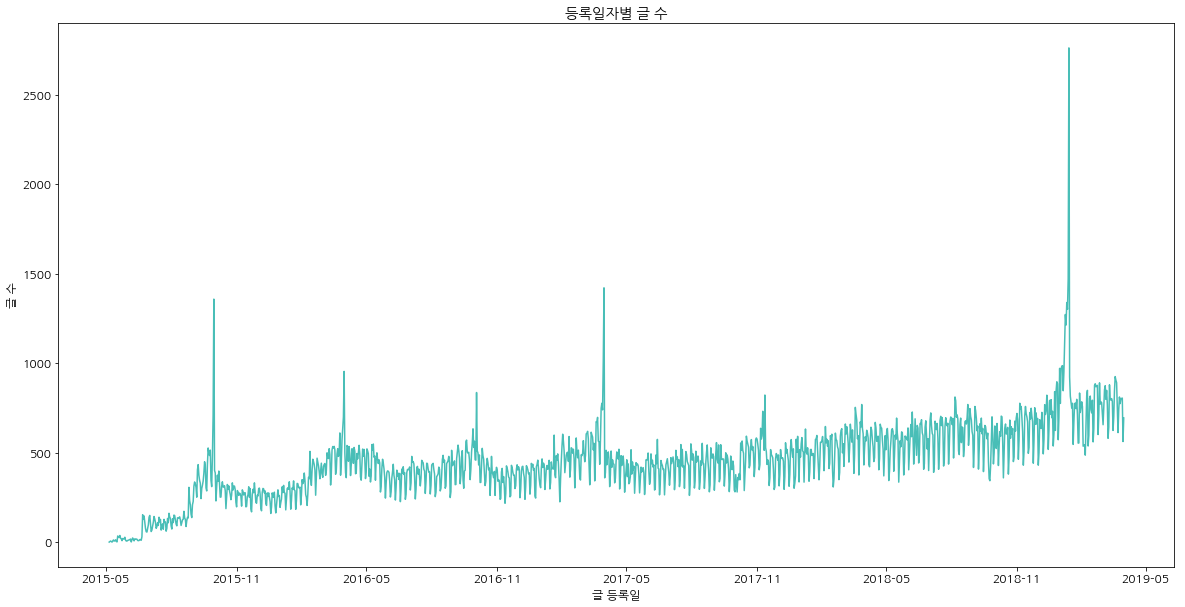

In [31]:
sns.lineplot(data=atc_cnt_by_reg_dt[:-1], x='reg_dt', y='article_id', color='#49beb7')
plt.title('등록일자별 글 수')
plt.xlabel('글 등록일')
plt.ylabel('글 수')

## 2. 글 소비

### a. 글별 소비수 통계

In [32]:
atc_read_cnt = read_raw[read_raw.article_id != ''].groupby('article_id')['user_id'].count()

In [33]:
# 글별 소비수 통계
atc_read_cnt.describe()

count    505840.000000
mean         43.700988
std         302.292764
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: user_id, dtype: float64

In [34]:
# 글별 소비수 85% 95% 기준 값
atc_read_cnt.quantile([0.85, 0.95])

0.85     47.0
0.95    141.0
Name: user_id, dtype: float64

In [35]:
atc_read_cnt = atc_read_cnt.reset_index()
atc_read_cnt.columns = ['article_id', 'read_cnt']

In [36]:
atc_read_cnt.tail()

,article_id,read_cnt
505835,@zzzaam_6,114
505836,@zzzaam_7,42
505837,@zzzaam_8,80
505838,@zzzaam_9,43
505839,@zzzwhite_4,2


In [37]:
#metadata 결합
atc_read_cnt = pd.merge(atc_read_cnt, atc, how='left', left_on='article_id', right_on='article_id')

In [38]:
atc_read_cnt.shape

(505840, 13)

In [39]:
atc_read_cnt.tail()

,article_id,read_cnt,id,display_url,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type
505835,@zzzaam_6,114,6.0,https://brunch.co.kr/@zzzaam/6,"[디자인, UX, design]",0.0,1.489403e+12,Hacking Product Design,좋은 제품 UX 디자인을 위한 9가지 방법,@zzzaam,2017-03-13 20:08:01,2017-03-13,개인
505836,@zzzaam_7,42,7.0,https://brunch.co.kr/@zzzaam/7,"[UX, 전략, 사용성]",0.0,1.490278e+12,Iteration is not design,반복적 디자인에 대한 소고,@zzzaam,2017-03-23 23:00:17,2017-03-23,개인
505837,@zzzaam_8,80,8.0,https://brunch.co.kr/@zzzaam/8,"[인공지능, AI, 디자인]",0.0,1.493136e+12,AI와 휴머니티의 간극,인공지능과 미래의 디자인: 2025년의 디자이너,@zzzaam,2017-04-26 00:57:34,2017-04-26,개인
505838,@zzzaam_9,43,9.0,https://brunch.co.kr/@zzzaam/9,"[UX, 작가, 글쓰기]",0.0,1.496501e+12,Writers + Designers = A match made in he,디자인팀에 작가가 필요한 이유,@zzzaam,2017-06-03 23:39:22,2017-06-03,개인
505839,@zzzwhite_4,2,4.0,https://brunch.co.kr/@zzzwhite/4,"[감성그림, 희망, 엄마]",0.0,1.467290e+12,감성드로잉,너는 희망이다.,@zzzwhite,2016-06-30 21:30:54,2016-06-30,개인


In [40]:
# metadata를 찾을 수 없는 소비 로그 제외
atc_read_cnt_nn = atc_read_cnt[atc_read_cnt['id'].notnull()]

In [41]:
# metadata를 찾을 수 없는 로그를 제외한 후 글별 소비수 통계
atc_read_cnt_nn['read_cnt'].describe()

count    476147.000000
mean         43.904592
std         304.873256
min           1.000000
25%           3.000000
50%           8.000000
75%          25.000000
max       97206.000000
Name: read_cnt, dtype: float64

In [42]:
# 글별 소비수 90% 95% 기준 값
atc_read_cnt_nn['read_cnt'].quantile([0.90, 0.95])

0.90     72.0
0.95    142.0
Name: read_cnt, dtype: float64

In [43]:
# 소비수 기준 분류값
def get_class(x):
    if x >= 142:
        result = '5%'
    elif x >= 72:
        result = '10%'
    elif x >= 25:
        result = '25%'
    elif x >= 8:
        result = '50%'
    elif x >= 3:
        result = '75%'
    else:
        result = '100%'
    return result

In [44]:
atc_read_cnt_nn['class'] = atc_read_cnt_nn['read_cnt'].map(get_class)

/data/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
atc_read_cnt_nn.head()

,article_id,read_cnt,id,display_url,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type,class
5417,@002_10,2,10.0,https://brunch.co.kr/@002/10,"[계란, 살충제, 피해]",0.0,1.504448e+12,정직한 농가에 대한 피해보상은 소비자 신뢰를 돌려주는 것,'80% 안심계란' 포기하게 한 20% 살충제 계란,@002,2017-09-03 23:12:35,2017-09-03,개인,100%
5418,@002_2,6,2.0,https://brunch.co.kr/@002/2,"[귀촌, 농촌, 청년농업인]",0.0,1.501030e+12,삶의 가치를 찾아 유랑하는 청년들의 'YOLO 라이프',청년들은 '왜' 농촌으로 갔을까?,@002,2017-07-26 09:46:45,2017-07-26,개인,75%
5419,@002jesus_1,10,1.0,https://brunch.co.kr/@002jesus/1,"[후원, 기부, 비영리]",0.0,1.549456e+12,비영리를 바라보는 편견들 (1),우리는 왜 가난해야 하나요?,@002jesus,2019-02-06 21:18:49,2019-02-06,개인,50%
5420,@002paper_2,3,2.0,https://brunch.co.kr/@002paper/2,"[제주, 서울생활, 서울]",0.0,1.470905e+12,현실과 꿈의 거리..,할수 있는 것과 하고 싶은 것,@002paper,2016-08-11 17:49:42,2016-08-11,개인,75%
5421,@002paper_3,2,3.0,https://brunch.co.kr/@002paper/3,"[바램, 일상에세이, 긍정]",0.0,1.470913e+12,된다. 된다. 될거다....,긍정적으로 생각하며 주문을 걸기..,@002paper,2016-08-11 19:58:52,2016-08-11,개인,100%


### b. 등록일자별 글 소비수

Text(0,0.5,'글 소비수')

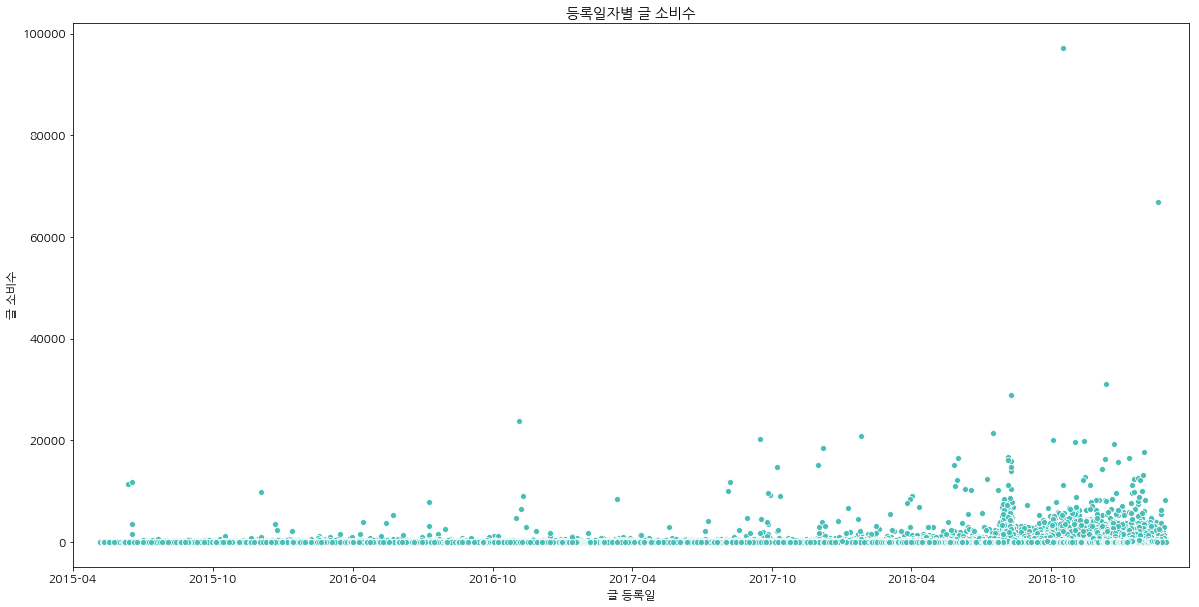

In [46]:
lm = sns.scatterplot(data=atc_read_cnt_nn, x='reg_dt', y='read_cnt', color='#49beb7')
lm.set(xlim=(datetime.date(datetime(2015, 4, 1)), datetime.date(datetime(2019, 3, 30))))
plt.title('등록일자별 글 소비수')
plt.xlabel('글 등록일')
plt.ylabel('글 소비수')

- 두 개의 아티클이 글 소비수가 매우 높음 
- 그래프를 자세히 보기 위해 두 개의 아티클을 제외하고 다시 그려보자

In [47]:
atc_read_cnt_nn.sort_values(by='read_cnt', ascending=False).head(2)

,article_id,read_cnt,id,display_url,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type,class
63061,@brunch_141,97206,141.0,https://brunch.co.kr/@brunch/141,"[브런치X빨강머리앤, 빨강머리앤, 출판, 작가]",0.0,1.539742e+12,글·그림 작가 파트너 프로젝트,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,@brunch,2018-10-17 11:11:22,2018-10-17,개인,5%
63070,@brunch_151,66903,151.0,https://brunch.co.kr/@brunch/151,"[브런치, 시사회, 브런치무비패스]",0.0,1.550466e+12,브런치 무비 패스 5기 작가 모집,"브런치 무비 패스, 영화의 진한 여운을 나누세요",@brunch,2019-02-18 14:00:34,2019-02-18,개인,5%


Text(0,0.5,'글 소비수')

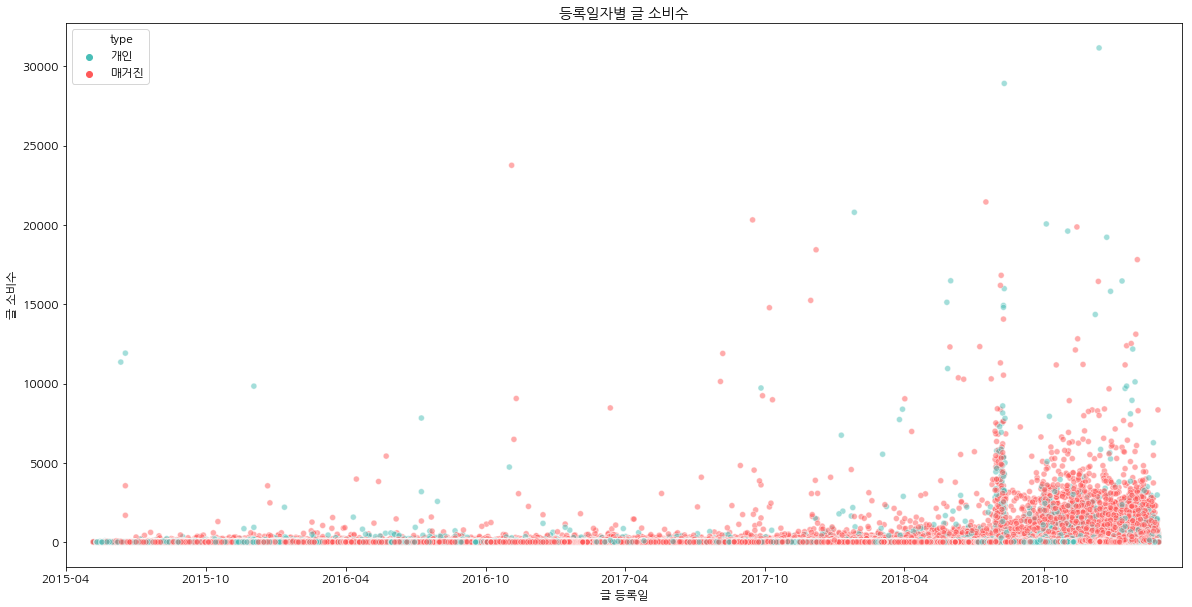

In [48]:
# 특이값 2개 데이터를 제외
lm = sns.scatterplot(data=atc_read_cnt_nn[~atc_read_cnt_nn.article_id.isin(['@brunch_141', '@brunch_151'])], x='reg_dt', y='read_cnt', hue='type', alpha=0.5, palette=['#49beb7', '#ff5959'])
lm.set(xlim=(datetime.date(datetime(2015, 4, 1)), datetime.date(datetime(2019, 3, 30))))
plt.title('등록일자별 글 소비수')
plt.xlabel('글 등록일')
plt.ylabel('글 소비수')

## 3. 경과일에 따른 글 소비 변화

### a. 데이터 전처리

In [49]:
off_data = pd.merge(read_raw, atc, how='inner', left_on='article_id', right_on='article_id')

In [50]:
off_data.shape

(20905040, 15)

In [51]:
off_data.head()

,dt,hr,user_id,article_id,id,display_url,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type
0,20181001,00,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91,91,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,1538321174000,문제는 만남의 '기회'가 아닌 만남의 '기준',좋은 이성을 만나는 기준,@kty0613,2018-10-01 00:26:14,2018-10-01,매거진
1,20181001,00,#e6097910257c8b79380da50b4bce705b,@kty0613_91,91,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,1538321174000,문제는 만남의 '기회'가 아닌 만남의 '기준',좋은 이성을 만나는 기준,@kty0613,2018-10-01 00:26:14,2018-10-01,매거진
2,20181001,00,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,91,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,1538321174000,문제는 만남의 '기회'가 아닌 만남의 '기준',좋은 이성을 만나는 기준,@kty0613,2018-10-01 00:26:14,2018-10-01,매거진
3,20181001,00,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,91,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,1538321174000,문제는 만남의 '기회'가 아닌 만남의 '기준',좋은 이성을 만나는 기준,@kty0613,2018-10-01 00:26:14,2018-10-01,매거진
4,20181001,00,#bd4b6d5a32bcbe4a81419309af898630,@kty0613_91,91,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,1538321174000,문제는 만남의 '기회'가 아닌 만남의 '기준',좋은 이성을 만나는 기준,@kty0613,2018-10-01 00:26:14,2018-10-01,매거진


In [52]:
off_data.columns = ['read_dt', 'hr', 'user_id', 'article_id', 'article_seq', 'display_url',
                    'keyword_list', 'magazine_id', 'reg_ts', 'sub_title', 'title',
                    'author_id', 'reg_datetime', 'reg_dt', 'type']

In [53]:
off_data = off_data[['read_dt', 'user_id', 'article_id', 'title', 'sub_title', 'author_id', 'reg_dt', 'type', 'display_url', 'keyword_list', 'magazine_id']]

In [54]:
off_data['read_dt'] = pd.to_datetime(off_data['read_dt'], format='%Y%m%d')
off_data['reg_dt'] = pd.to_datetime(off_data['reg_dt'], format='%Y-%m-%d')
off_data['off_day'] = (off_data['read_dt'] - off_data['reg_dt']).dt.days

In [55]:
# meatadata와 join
off_data = pd.merge(off_data, atc_read_cnt_nn[['article_id', 'read_cnt', 'class']], how='left', left_on='article_id', right_on='article_id')

In [56]:
off_data.shape

(20905040, 14)

In [57]:
off_data.head()

,read_dt,user_id,article_id,title,sub_title,author_id,reg_dt,type,display_url,keyword_list,magazine_id,off_day,read_cnt,class
0,2018-10-01,#e208be4ffea19b1ceb5cea2e3c4dc32c,@kty0613_91,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',@kty0613,2018-10-01,매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298,5%
1,2018-10-01,#e6097910257c8b79380da50b4bce705b,@kty0613_91,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',@kty0613,2018-10-01,매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298,5%
2,2018-10-01,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',@kty0613,2018-10-01,매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298,5%
3,2018-10-01,#abfa7b43a9c3f4894ca450b0436fcd38,@kty0613_91,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',@kty0613,2018-10-01,매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298,5%
4,2018-10-01,#bd4b6d5a32bcbe4a81419309af898630,@kty0613_91,좋은 이성을 만나는 기준,문제는 만남의 '기회'가 아닌 만남의 '기준',@kty0613,2018-10-01,매거진,https://brunch.co.kr/@kty0613/91,"[연애, 남자친구, 이성]",38720,0,298,5%


In [58]:
off_data_agg = off_data.groupby(['article_id', 'off_day', 'read_dt', 'reg_dt', 'title', 'author_id', 'type', 'display_url', 'magazine_id', 'class'], as_index=False)['user_id'].count()

In [59]:
# 등록일자가 missing된 로그들
off_data_agg[off_data_agg.off_day < 0].head()

,article_id,off_day,read_dt,reg_dt,title,author_id,type,display_url,magazine_id,class,user_id
166,@01023920600_18,-26324,2018-12-05,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,2
167,@01023920600_18,-26303,2018-12-26,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,2
168,@01023920600_18,-26280,2019-01-18,2090-12-31,김영화가,@01023920600,매거진,https://brunch.co.kr/@01023920600/18,8123,75%,1
172,@01023920600_2,-26324,2018-12-05,2090-12-31,효자되는 소액투자 돈불리는 소액투자,@01023920600,개인,https://brunch.co.kr/@01023920600/2,0,75%,2
173,@01023920600_2,-26303,2018-12-26,2090-12-31,효자되는 소액투자 돈불리는 소액투자,@01023920600,개인,https://brunch.co.kr/@01023920600/2,0,75%,2


### b. 경과일에 따른 글 소비 변화

In [60]:
# 경과일자별 소비수 총합
off_day_sum = off_data_agg[(off_data_agg['reg_dt'] >= datetime(2018, 10, 1)) & (off_data_agg.off_day >= 0)].groupby('off_day')['user_id'].sum()

In [61]:
# 경과일자에 등록되어있는 아티클 수
reg_dt_cnt = off_data_agg[(off_data_agg['reg_dt'] >= datetime(2018, 10, 1)) & (off_data_agg.off_day >= 0)].groupby('reg_dt')['article_id'].nunique()

In [62]:
off_day_avg = pd.concat([off_day_sum, reg_dt_cnt.cumsum().sort_index(ascending=False).reset_index()], axis=1)

In [63]:
off_day_avg['off_avg'] = off_day_avg['user_id'] / off_day_avg['article_id']

In [64]:
off_day_avg['percentile'] = off_day_avg['off_avg'] / off_day_avg['off_avg'].sum()

In [65]:
off_day_avg['cum_per'] = off_day_avg['percentile'].cumsum()

In [66]:
off_day_avg.head(10)

,user_id,reg_dt,article_id,off_avg,percentile,cum_per
0,3142049,2019-02-28,107356,29.267568,0.207084,0.207084
1,1726882,2019-02-27,106649,16.192201,0.114569,0.321653
2,1017862,2019-02-26,105891,9.612356,0.068013,0.389665
3,776093,2019-02-25,105156,7.380397,0.052220,0.441886
4,632960,2019-02-24,104308,6.068183,0.042936,0.484821
5,529081,2019-02-23,103611,5.106417,0.036131,0.520952
6,436611,2019-02-22,103019,4.238160,0.029987,0.550939
7,412530,2019-02-21,102167,4.037801,0.028570,0.579509
8,236772,2019-02-20,101343,2.336343,0.016531,0.596040
9,193039,2019-02-19,100511,1.920576,0.013589,0.609629


Text(0,0.5,'평균 글 소비수')

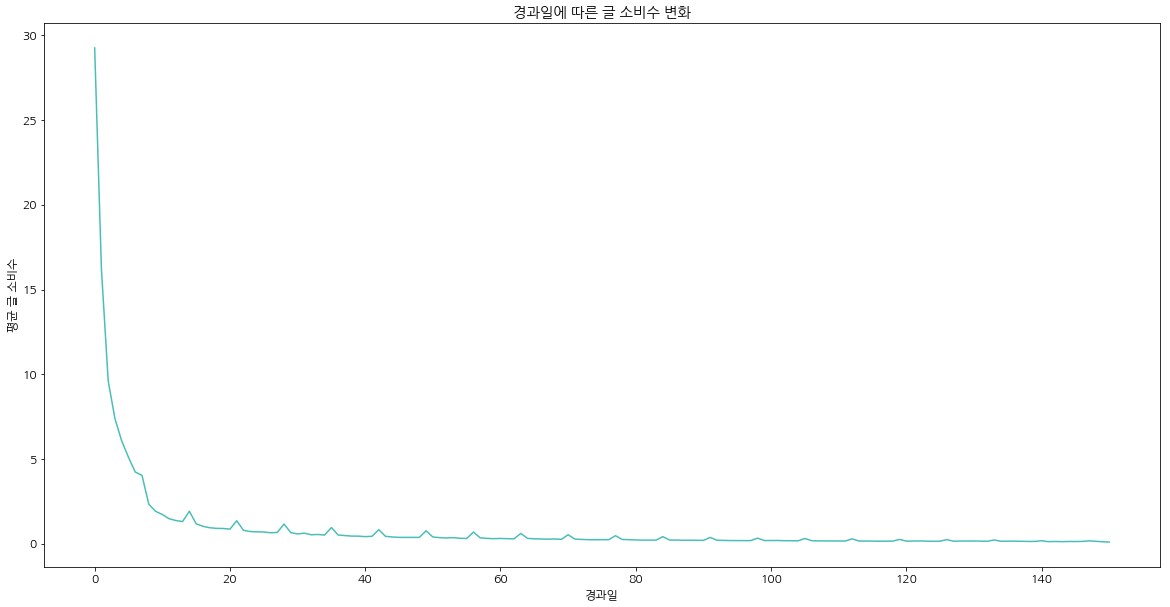

In [67]:
sns.lineplot(data=off_day_avg, x=off_day_avg.index, y='off_avg', color='#49beb7')
plt.title('경과일에 따른 글 소비수 변화')
plt.xlabel('경과일')
plt.ylabel('평균 글 소비수')

## 4. 위클리 매거진

In [68]:
magazine_34075 = atc_read_cnt_nn[atc_read_cnt_nn.magazine_id == 34075]

In [69]:
# Weekly매거진 회사 체질이 아니라서요 (by 서메리) 글 목록
magazine_34075

,article_id,read_cnt,id,display_url,keyword_list,magazine_id,reg_ts,sub_title,title,author_id,reg_datetime,reg_dt,type,class
299425,@merryseo_51,3946,51.0,https://brunch.co.kr/@merryseo/51,"[퇴사, 일러스트, 에세이]",34075.0,1.532531e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,"""프리랜서입니다""",@merryseo,2018-07-26,2018-07-26,매거진,5%
299426,@merryseo_52,4906,52.0,https://brunch.co.kr/@merryseo/52,"[퇴사, 에세이, 일러스트]",34075.0,1.533136e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,퇴사를 결심하다,@merryseo,2018-08-02,2018-08-02,매거진,5%
299427,@merryseo_53,7620,53.0,https://brunch.co.kr/@merryseo/53,"[퇴사, 에세이, 일러스트]",34075.0,1.533740e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,회사 체질이 아니야,@merryseo,2018-08-09,2018-08-09,매거진,5%
299428,@merryseo_54,3134,54.0,https://brunch.co.kr/@merryseo/54,"[퇴사, 프리랜서, 에세이]",34075.0,1.534345e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,프리랜서? 좋지. 근데 기술은 있고?,@merryseo,2018-08-16,2018-08-16,매거진,5%
299429,@merryseo_55,3112,55.0,https://brunch.co.kr/@merryseo/55,"[프리랜서, 퇴사, 에세이]",34075.0,1.534950e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,생각보다 넓고 깊은 프리랜서의 세계,@merryseo,2018-08-23,2018-08-23,매거진,5%
299430,@merryseo_56,2942,56.0,https://brunch.co.kr/@merryseo/56,"[퇴사, 프리랜서, 에세이]",34075.0,1.535555e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,세상에서 가장 소심한 퇴사 준비,@merryseo,2018-08-30,2018-08-30,매거진,5%
299431,@merryseo_57,2745,57.0,https://brunch.co.kr/@merryseo/57,"[퇴사, 프리랜서, 에세이]",34075.0,1.536160e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,한 달 동안의 아주 사치스러운 백수 생활,@merryseo,2018-09-06,2018-09-06,매거진,5%
299432,@merryseo_58,2522,58.0,https://brunch.co.kr/@merryseo/58,"[퇴사, 프리랜서, 에세이]",34075.0,1.536764e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,이렇게 평범한 내가 프리랜서를?,@merryseo,2018-09-13,2018-09-13,매거진,5%
299433,@merryseo_59,2687,59.0,https://brunch.co.kr/@merryseo/59,"[프리랜서, 퇴사, 에세이]",34075.0,1.537369e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,역시 사람은 기술을 배워야 혀~,@merryseo,2018-09-20,2018-09-20,매거진,5%
299435,@merryseo_61,3356,61.0,https://brunch.co.kr/@merryseo/61,"[퇴사, 프리랜서, 일상툰]",34075.0,1.537974e+12,기술도 없는 사무직 퇴사자의 프리랜서 도전기,뭔가 플러스 알파가 필요해,@merryseo,2018-09-27,2018-09-27,매거진,5%


In [70]:
magazine_34075_read = off_data_agg[off_data_agg.magazine_id == 34075]

In [71]:
magazine_34075_read.head()

,article_id,off_day,read_dt,reg_dt,title,author_id,type,display_url,magazine_id,class,user_id
2630367,@merryseo_51,67,2018-10-01,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16
2630368,@merryseo_51,68,2018-10-02,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,25
2630369,@merryseo_51,69,2018-10-03,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16
2630370,@merryseo_51,70,2018-10-04,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,308
2630371,@merryseo_51,71,2018-10-05,2018-07-26,"""프리랜서입니다""",@merryseo,매거진,https://brunch.co.kr/@merryseo/51,34075,5%,16


Text(0,0.5,'글 소비수')

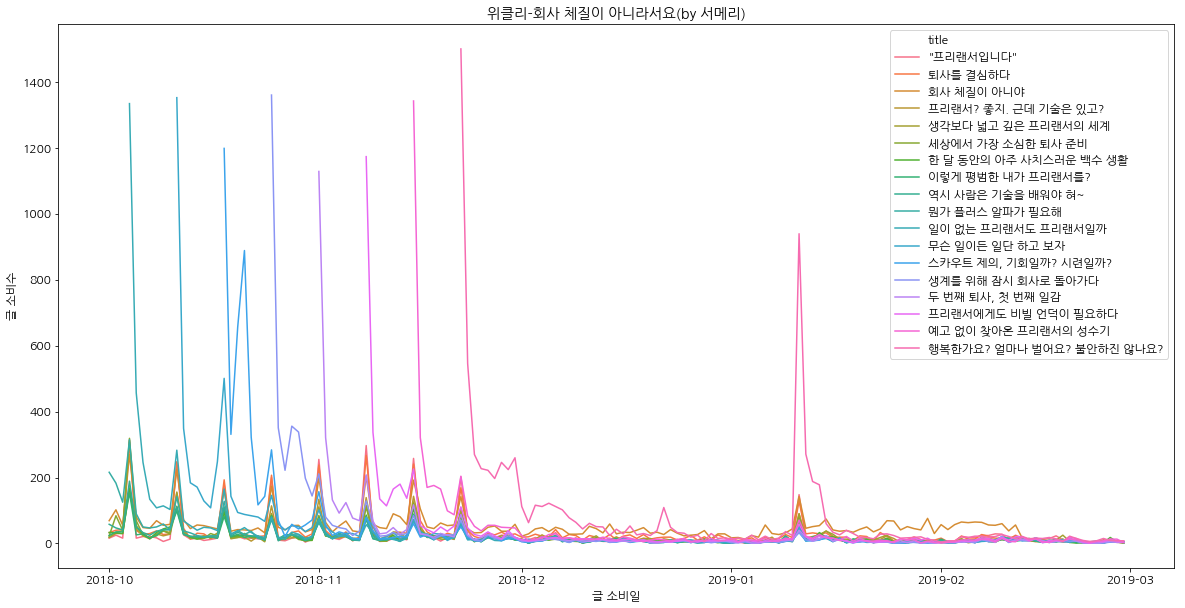

In [72]:
sns.lineplot(data=magazine_34075_read, x='read_dt', y='user_id', hue='title')
plt.title('위클리-회사 체질이 아니라서요(by 서메리)')
plt.xlabel('글 소비일')
plt.ylabel('글 소비수')

## 5. 유저

In [73]:
# 유져별 방문일수, 글 소비수
grp_by_user = off_data.groupby('user_id').agg({'read_dt':['nunique', 'count']})

In [74]:
grp_by_user = grp_by_user.reset_index()
grp_by_user.columns = ['user_id', 'visit_day_cnt', 'read_cnt']

In [75]:
grp_by_user.head()

,user_id,visit_day_cnt,read_cnt
0,#00001ba6ca8d87d2fc34d626ba9cfe6f,1,3
1,#0000e87158c1426d6ffb72cebac6cb64,1,2
2,#0000eea6d339abfd02ed590bc451fc63,1,1
3,#0000fdba8f35c76eacab74c5c6bc7f1a,3,11
4,#000127ad0f1981cae1292efdb228f0e9,1,27


### a. 방문일수 기준 유저 통계

In [76]:
grp_by_user['visit_day_cnt'].value_counts(normalize=True).head()

1    0.352137
2    0.142516
3    0.088841
4    0.063050
5    0.047217
Name: visit_day_cnt, dtype: float64

In [77]:
grp_by_user['visit_day_cnt'].value_counts(normalize=True).sort_index()[74:].sum()

0.009034902176890052

- 1~2회 방문 유저 전체 유저중 50%

- 75회 이상 방문하는유저 전체 유저중 약 1%

- 1~2일 방문유저를 신규유저 / 75일(Train 기간 절반 방문) 방문 유저를 단골유저로 구분

In [78]:
low_visit_user = grp_by_user.loc[grp_by_user['visit_day_cnt'] <=2, 'user_id']

In [79]:
upp_visit_user = grp_by_user.loc[grp_by_user['visit_day_cnt'] >=75, 'user_id']

In [80]:
low_visit_user.shape, upp_visit_user.shape

((149903,), (2738,))

In [81]:
off_data_l = off_data[off_data.user_id.isin(low_visit_user)]
off_data_u = off_data[off_data.user_id.isin(upp_visit_user)]

In [82]:
off_data.shape, off_data_l.shape, off_data_u.shape

((20905040, 14), (1083925, 14), (5002114, 14))

In [83]:
1083925/20905040, 5002114/20905040

(0.051849936665990595, 0.23927789662205862)

- 신규 유저의 글 소비는 전체의 5%, 단골 유저의 글 소비는 전체의 24%

In [84]:
off_data_l.groupby('user_id')['article_id'].count().mean(), off_data_l.groupby('user_id')['article_id'].count().std(), 

(7.230842611555473, 13.573547204837958)

In [85]:
off_data_u.groupby('user_id')['article_id'].count().mean(), off_data_u.groupby('user_id')['article_id'].count().std()

(1826.9225712198686, 2758.1071094196964)

- 신규 유저의 평균 글 소비수는 7, 표준편차 14
- 단골 유저의 평균 글 소비수는 1827, 표준편차 2758

### b. 신규/단골 그룹내 인기 글

In [86]:
off_data_l_rk = off_data_l.groupby(['article_id', 'title', 'reg_dt'])['user_id'].count().sort_values(ascending=False)
off_data_l_rk = off_data_l_rk.reset_index()
off_data_l_rk['rk'] = off_data_l_rk.index + 1

In [87]:
off_data_u_rk = off_data_u.groupby(['article_id', 'title', 'reg_dt'])['user_id'].count().sort_values(ascending=False)
off_data_u_rk = off_data_u_rk.reset_index()
off_data_u_rk['rk'] = off_data_u_rk.index + 1

In [88]:
# 신규 독자 소비수 상위 상위 10개 글
off_data_l_rk.head(10)

,article_id,title,reg_dt,user_id,rk
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,13519,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,8160,2
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282,3
3,@brunch_140,카카오 크리에이터스 스튜디오에서 브런치 작가를 만나다.,2018-10-04,4343,4
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068,5
5,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,2897,6
6,@brunch_133,"또 다른 기회의 시작, 브런치와 함께하세요",2018-07-09,2640,7
7,@kakaomobility_20,음성으로 편리하게,2018-10-17,2458,8
8,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2226,9
9,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2221,10


In [89]:
# 단골 독자 소비수 상위 상위 10개 글
off_data_u_rk.head(10)

,article_id,title,reg_dt,user_id,rk
0,@brunch_141,브런치 작가가 함께 빨강머리 앤을 그리고 쓰다.,2018-10-17,11636,1
1,@brunch_151,"브런치 무비 패스, 영화의 진한 여운을 나누세요",2019-02-18,6010,2
2,@brunch_145,"10인의 에디터와 함께 하는, 브런치북 프로젝트 #6",2018-12-12,4379,3
3,@tenbody_1305,러닝머신보다 효과 좋은 체지방 빼는 맨몸 운동 5가지,2018-08-10,3674,4
4,@hyehyodam_19,나쁜년이 잘 사는 이유...,2018-01-26,2920,5
5,@sangheeshyn_66,살찌지 않는 여자들,2018-11-13,2866,6
6,@brunch_142,[예고] 브런치북 프로젝트 #6,2018-11-01,2753,7
7,@intlovesong_28,아끼면 똥 되는 것 4가지,2016-11-04,2606,8
8,@x-xv_19,"승무원, 들어오려는 자, 나가려는 자",2018-08-05,2603,9
9,@steven_179,친구 없는 사람의 3가지 특징,2017-09-15,2597,10


In [90]:
off_data_lu_rk = pd.merge(off_data_l_rk, off_data_u_rk, how='outer', left_on = 'article_id', right_on='article_id')

In [91]:
off_data_lu_rk['diff_rk'] = off_data_lu_rk['rk_x'] - off_data_lu_rk['rk_y'] 

In [92]:
# 신규 독자 소비수 상위 50개 글 중 단골 독자의 순위 차가 많이 나는 글
off_data_lu_rk[off_data_lu_rk.rk_x <= 50].sort_values(by='diff_rk', ascending=True).head(10)

,article_id,title_x,reg_dt_x,user_id_x,rk_x,title_y,reg_dt_y,user_id_y,rk_y,diff_rk
7,@kakaomobility_20,음성으로 편리하게,2018-10-17,2458.0,8.0,음성으로 편리하게,2018-10-17,14.0,64179.0,-64171.0
4,@brunch_2,브런치 작가 신청 안내,2015-06-18,4068.0,5.0,브런치 작가 신청 안내,2015-06-18,232.0,3216.0,-3211.0
33,@brunch_139,작가님에게 새로운 제안이 도착했습니다,2018-08-08,1047.0,34.0,작가님에게 새로운 제안이 도착했습니다,2018-08-08,474.0,750.0,-716.0
18,@brunch_152,작가 인터뷰 - 임희정 아나운서의 고백,2019-02-27,1611.0,19.0,작가 인터뷰 - 임희정 아나운서의 고백,2019-02-27,480.0,730.0,-711.0
2,@brunch_1,"글이 작품이 되는 공간, 브런치",2015-06-12,5282.0,3.0,"글이 작품이 되는 공간, 브런치",2015-06-12,528.0,569.0,-566.0
26,@brunch_111,브런치 책방에 작가님의 책을 입고해주세요,2017-09-28,1326.0,27.0,브런치 책방에 작가님의 책을 입고해주세요,2017-09-28,702.0,315.0,-288.0
35,@jmg5308_163,이효리를 통해 바라본 자존감 높은 사람의 특징,2017-08-04,995.0,36.0,이효리를 통해 바라본 자존감 높은 사람의 특징,2017-08-04,795.0,233.0,-197.0
38,@dong02_1372,자존감을 높이는 언어습관 3가지 방법,2017-10-11,876.0,39.0,자존감을 높이는 언어습관 3가지 방법,2017-10-11,880.0,185.0,-146.0
31,@nplusu_49,벨기에의 3가지 보물,2016-11-10,1170.0,32.0,벨기에의 3가지 보물,2016-11-10,900.0,175.0,-143.0
45,@needleworm_1,크롤러를 이용해 우체국 등기우편을 자동으로 정리해 보자,2018-11-01,796.0,46.0,크롤러를 이용해 우체국 등기우편을 자동으로 정리해 보자,2018-11-01,905.0,173.0,-127.0


In [93]:
# 단골 독자 소비수 상위 50개 글 중 신규 독자의 순위 차가 많이 나는 긂
off_data_lu_rk[off_data_lu_rk.rk_y <= 50].sort_values(by='diff_rk', ascending=False).head(10)

,article_id,title_x,reg_dt_x,user_id_x,rk_x,title_y,reg_dt_y,user_id_y,rk_y,diff_rk
753,@doyeonsunim_240,자기 관리의 시작,2018-08-06,117.0,754.0,자기 관리의 시작,2018-08-06,1608.0,37.0,717.0
504,@boboc_72,"여름, 수박을 먹는 계절",2018-08-12,151.0,505.0,"여름, 수박을 먹는 계절",2018-08-12,1473.0,49.0,456.0
434,@kam_33,많이 먹은 다음날 반드시 지켜야 할 3가지 습관,2018-08-09,167.0,435.0,많이 먹은 다음날 반드시 지켜야 할 3가지 습관,2018-08-09,1751.0,29.0,406.0
261,@jooyoon_51,구질구질한 연애,2018-08-01,227.0,262.0,구질구질한 연애,2018-08-01,1750.0,30.0,232.0
211,@greenut90_85,크림라떼와 브라우니,2018-08-05,257.0,212.0,크림라떼와 브라우니,2018-08-05,1573.0,41.0,171.0
199,@roysday_279,혼자서 어찌어찌 하다보니 1억을 넘겼다.,2018-11-03,266.0,200.0,혼자서 어찌어찌 하다보니 1억을 넘겼다.,2018-11-03,1659.0,36.0,164.0
162,@honeytip_940,뱃살 쏙 들어가게 하는 건강한 먹거리 6가지,2018-08-09,305.0,163.0,뱃살 쏙 들어가게 하는 건강한 먹거리 6가지,2018-08-09,2408.0,12.0,151.0
136,@tenbody_1297,매일 5분씩 참으면서 살 빼고 근육 늘리는 방법,2018-08-09,346.0,137.0,매일 5분씩 참으면서 살 빼고 근육 늘리는 방법,2018-08-09,2244.0,15.0,122.0
149,@merryseo_73,행복한가요? 얼마나 벌어요? 불안하진 않나요?,2018-11-22,318.0,150.0,행복한가요? 얼마나 벌어요? 불안하진 않나요?,2018-11-22,1742.0,31.0,119.0
115,@honeytip_945,물에 오이를 넣어 마시면 생기는 몸의 변화 5가지,2018-08-10,392.0,116.0,물에 오이를 넣어 마시면 생기는 몸의 변화 5가지,2018-08-10,2227.0,16.0,100.0


## 6. Following List

### a. Following List 통계

In [94]:
# following_list가 있는 유저
following = users[users['following_list'].str.len() !=0 ]

In [95]:
following.shape[0] / users.shape[0]

0.9766120260781701

- 98%의 유저가 follow하는 작가가 있음

In [96]:
following['author_cnt'] = users['following_list'].str.len()

/data/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
#평균 구독자수 
following['author_cnt'].mean()

8.622620185179084

- follow하고 있는 유저는 평균 9명의 작가를 구독 중

In [98]:
following['following_list'] = following['following_list'].apply(lambda x: ' '.join(x))

/data/app/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(' ')))

In [100]:
following_lens = following['following_list'].str.split(' ').map(len)

In [101]:
following_raw = pd.DataFrame({'id': np.repeat(following['id'], following_lens),
                         'following_list': chainer(following['following_list'])})

In [102]:
# 가장 구독하는 유저가 많은 작가 리스트
following_raw['following_list'].value_counts(ascending=False)[:20]

@brunch         292413
@dryjshin         9011
@tenbody          8615
@roysday          8500
@yumileewyky      6116
@varo             5688
@yoonash          5653
@imagineer        5483
@lunarshore       5414
@ebprux           5374
@haneulalice      5341
@suhanjang        4911
@daljasee         4756
@mobiinside       4743
@sustainlife      4655
@bang1999         4577
@seochogirl       4441
@annejeong        4426
@eastgo           4387
@hyejinchoi       4305
Name: following_list, dtype: int64

In [103]:
following_read = pd.merge(off_data, following_raw, how='inner', left_on=['user_id', 'author_id'], right_on=['id', 'following_list'])

In [104]:
following_read.shape[0] / off_data.shape[0]

0.3485478621423351

- 전체 소비 데이터중 구독하고 있는 작가의 글 소비 비중이 35%